In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import tensorflow_datasets as tfds
from random import randint

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import time

c:\Users\gs_ke\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# HW5

For this homework, we are going to use [CELEB-A dataset](https://www.tensorflow.org/datasets/catalog/celeb_a). CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations, including - 10,177 number of identities, - 202,599 number of face images, and - 5 landmark locations, 40 binary attributes annotations per image.

Follow the step-by-step instructions below to dowload data.

## Downloading the CELEB-A Dataset 

In this section, I will guide you to manually fetch and install the CELEB-A dataset so that TensorFlow Datasets (TFDS) can load it properly for this homework.


### Step 1: Create a Local Dataset Directory

Choose a directory on your machine to store TensorFlow datasets (replace with your preferred path). We will refer to this path as your `DATA_DIR`. For me the setup is like below, but you should change it for your setup accordingly. If the directory does not exist, create it.

In [2]:
# WRITE THE LOCATION OF THE DATA DIRECTORY
DATA_DIR = r"C:\Class\MYZ309E\HW5\data\tensorflow_datasets"

### Step 2: Manually Download the Dataset

TensorFlow cannot automatically fetch CELEB-A due to Google Drive download restrictions. Follow these steps:

1. Open the official download link in a browser:

   [https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view](https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view)

   Click the **"Download anyway"** button (you may need to wait or confirm warnings about large files).

2. This will download a file named: `img_align_celeba.zip`

3. After download completes, **create a subdirectory** called `downloads/manual` and **move the file into the manual data directory**. In my case this is "/home/kaygun/local/data/tensorflow_datasets/dowloads/manual/".

### Step 3: Prepare the Dataset with TensorFlow Datasets

Once the file is in place, use the following Python code to prepare the dataset:

In [3]:
# Initialize and prepare the dataset builder
builder = tfds.builder('celeb_a', data_dir=DATA_DIR)

builder.download_and_prepare(download_config=tfds.download.DownloadConfig(
    manual_dir=f"{DATA_DIR}/downloads/manual",
    download_mode=tfds.download.GenerateMode.REUSE_CACHE_IF_EXISTS
))

Dl Size...: 0 MiB [00:00, ? MiB/s]5/5 [00:00<00:00, 97.13 url/s] 
Dl Completed...: 100%|██████████| 5/5 [00:00<00:00, 79.52 url/s]


FileExistsError: Cannot rename C:\Class\MYZ309E\HW5\data\tensorflow_datasets\celeb_a\2.1.0.incompleteZOO7F5. Destination C:\Class\MYZ309E\HW5\data\tensorflow_datasets\celeb_a\2.1.0 already exists.

After this step, the dataset will be extracted, validated, and cached in a format that can be loaded.

### Notes

- The CELEB-A dataset is ~1.3 GB. Make sure you have enough disk space.
- Do **not unzip** the archive. TFDS expects the raw `.zip` file.
- The dataset will only need to be downloaded once; subsequent runs will use the cached version.

## Ingesting the Dataset into Our Environment

Now, let us load up the data:


In [4]:
train_ds, val_ds, test_ds = tfds.load(
    'celeb_a',
    split=['train', 'validation', 'test'],
    data_dir=DATA_DIR,
    as_supervised=False
)

I'll take 10 random examples from the training set.

In [5]:
N = 500
examples = list(train_ds.take(N))

Now, let us display a random image together with the metadata attached (here called 'attributes') to the picture:

{'5_o_Clock_Shadow': <tf.Tensor: shape=(), dtype=bool, numpy=True>,
 'Arched_Eyebrows': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Attractive': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Bags_Under_Eyes': <tf.Tensor: shape=(), dtype=bool, numpy=True>,
 'Bald': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Bangs': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Big_Lips': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Big_Nose': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Black_Hair': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Blond_Hair': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Blurry': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Brown_Hair': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Bushy_Eyebrows': <tf.Tensor: shape=(), dtype=bool, numpy=True>,
 'Chubby': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Double_Chin': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Eyeglasses': <tf.Tensor: shape=(), dtype=bool, numpy=False

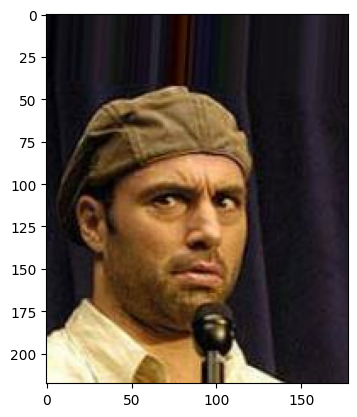

In [6]:
example = examples[randint(0,N)]
plt.imshow(example['image'])
example['attributes']

Here is another example with its attributes:

{'5_o_Clock_Shadow': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Arched_Eyebrows': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Attractive': <tf.Tensor: shape=(), dtype=bool, numpy=True>,
 'Bags_Under_Eyes': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Bald': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Bangs': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Big_Lips': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Big_Nose': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Black_Hair': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Blond_Hair': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Blurry': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Brown_Hair': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Bushy_Eyebrows': <tf.Tensor: shape=(), dtype=bool, numpy=True>,
 'Chubby': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Double_Chin': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Eyeglasses': <tf.Tensor: shape=(), dtype=bool, numpy=Fals

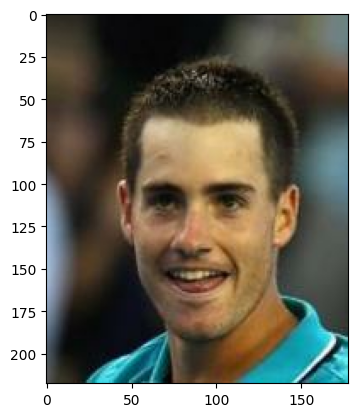

In [7]:
example = examples[randint(0,N)]
plt.imshow(example['image'])
example['attributes']

# Questions

In the questions below, you will construct and evaluate several classification models based on the CELEB-A dataset. Your goal is not only to develop accurate classifiers, but also to critically assess and compare the models through rigorous validation and analysis.

As before follow the rules stated below:

- Do not split your answers into separate files. All answers must be in a single jupyter notebook.
- Follow the step-by-step instructions provided at the beginning of this document to download and prepare the CELEB-A dataset using `tensorflow_datasets`. **DO NOT PUSH YOUR LOCAL COPY OF THE DATASET TO YOUR REPO**!!
- Refrain from using code comments to explain what has been done. Document your steps by writing appropriate markdown cells in your notebook.
- Avoid duplicating code by copying and pasting it from one cell to another. If copying and pasting is necessary, develop a suitable function for the task at hand and call that function.
- When providing parameters to a function, never use global variables. Instead, always pass parameters explicitly and always make use of local variables.
- Document your use of LLM models (ChatGPT, Claude, Code Pilot etc). You may
   + provide working links to your logs
   + take screenshots of your steps and include them with this notebook, or
   + give me a full log (both questions and answers) in a markdown file named HW5-LLM-LOG.md.

Failure to adhere to these guidelines will result in a 15-point deduction for each infraction.


## Q1 — Linear Models for Gender Classification

1. Train a **Support Vector Machine (SVM)** and a **Logistic Regression** model to classify the **gender** of the person in the image.
2. Evaluate both models using a rigorous **cross-validation scheme** and present a comprehensive **error analysis**.
3. **Select and justify** the model you believe is better suited to the task, both in terms of accuracy, precision, recall, and computational considerations.

In [29]:
def preprocess_image(example, image_size=(64, 64)):
    """CelebA örneğini işleyip düzleştirilmiş grayscale numpy vektörü döner."""
    image = tf.image.rgb_to_grayscale(example['image']) 
    image = tf.image.resize(image, image_size)          
    image = tf.reshape(image, [-1])                    
    image = tf.cast(image, tf.float32) / 255.0           
    return image.numpy()


In [30]:
def extract_label(example):
    return int(example['attributes']['Male'])

In [31]:
def get_dataset_arrays(dataset, n_samples=10000, image_size=(64, 64)):
    X_list = []
    y_list = []

    for i, example in enumerate(tfds.as_numpy(dataset)):
        if i >= n_samples:
            break
        x = preprocess_image(example, image_size=image_size)
        y = extract_label(example)
        X_list.append(x)
        y_list.append(y)

    return np.array(X_list), np.array(y_list)


In [ ]:
X_train, y_train = get_dataset_arrays(train_ds, n_samples=10000)

X_test, y_test = get_dataset_arrays(test_ds, n_samples=2500)

In [34]:
def evaluate_model(model, X, y, cv_folds=5):
    """Verilen modeli cross-validation ile değerlendirir ve metrikleri döndürür."""
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score)
    }

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    start = time.time()
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)
    duration = time.time() - start

    result = {
        'accuracy': scores['test_accuracy'].mean(),
        'precision': scores['test_precision'].mean(),
        'recall': scores['test_recall'].mean(),
        'f1_score': scores['test_f1'].mean(),
        'time_sec': duration
    }

    return result


In [35]:
logreg_model = LogisticRegression(max_iter=1000)
logreg_results = evaluate_model(logreg_model, X_train, y_train)

In [36]:
svm_model = SVC(kernel='linear')
svm_results = evaluate_model(svm_model, X_train, y_train)

In [ ]:
results_df = pd.DataFrame([
    {'Model': 'Logistic Regression', **logreg_results},
    {'Model': 'SVM (Linear)', **svm_results}
])

print(results_df)

                 Model  accuracy  precision    recall  f1_score    time_sec
0  Logistic Regression    0.8825   0.866026  0.851313  0.858586   64.150222
1         SVM (Linear)    0.8518   0.825808  0.819093  0.822405  406.607028


Bu ödevde cinsiyet sınıflandırması için iki farklı lineer model olan Lojistik Regresyon ve SVM(linear) algoritması uyguladım ve her iki model de aynı veri seti üzerinde 5-fold cross-validation ile değerlendirildi. Sonuçları doğrudan karşılaştırmak gerekirse, her iki modelin de oldukça yakın sonuçlar verdiği söylenebilir. Ancak metrikler ve zaman karmaşıklığı dikkate alındığında aralarında anlamlı farklar ortaya çıkmaktadır. 

İlk olarak doğruluk açısından değerlendirildiğinde, Lojistik Regresyon modeli SVM modeline göre çok az bir farkla daha yüksek bir başarı elde etmiştir. Precision ve Recall metriklerine bakıldığında ise Lojistik Regresyon modeli biraz daha dengeli bir performans sergilerken, bu model özellikle Recall değerinde öne çıkmıştır. Bu durum, Lojistik Regresyon'un pozitif sınıfları (örneğin erkek olarak etiketlenen sınıflar) daha iyi tanımlama eğiliminde olduğunu göstermektedir. Bu da uygulama bağlamına bağlı olarak önemli bir avantaj olabilir; örneğin, sistemin yanlışlıkla bir erkeği kadın olarak etiketlemesi daha ciddi bir sorun yaratıyorsa SVM tercih sebebi olabilir. 

F1-skora baktığımızda, bu iki model arasında farkın azaldığını görüyoruz. Bu da her iki modelin genel olarak dengeli ve benzer düzeyde performans gösterdiğini kanıtlıyor. Fakat model değerlendirmesini sadece doğruluk metriklerine indirgemek bence çok sağlıklı bir yaklaşım değil. Bu noktada hesaplama süreleri gibi değerlendirmelere de bakmak gerektiğini düşünüyorum. Lojistik Regresyon modelinin çok daha kısa sürede eğitildiği ve değerlendirildiğini sonuçlarımdan gözlemlemiş oldum. Özellikle büyük veri setleriyle çalışırken ya da hızlı sonuçlar alınması gereken durumlarda bu fark ciddi avantaj sağlayabilir. Bu veri seti için de acilen sonuçlandırılması gereken bir durum varsa Lojistik Regresyon modelinin kullanılması gerektiğini söyleyebiliriz.

Model performansına etki eden önemli bir diğer unsur da veri ön işleme adımlarıdır. Görseller gri tonlamaya çevrilip yeniden boyutlandırılarak her biri 64x64 çözünürlükte düzleştirilmiş vektörlere dönüştürülmüştür. Bu yaklaşım veriyi basitleştirerek modelin öğrenmesini kolaylaştırmakla birlikte, yüz ifadelerindeki ince detayların kaybolmasına da yol açabilir. Yani benim projemde çok önemli ayrıntılar yok olmuş olabilir. Her iki model de bu sadeleştirilmiş veriyi kullanarak öğrenme gerçekleştirdiği için, elde edilen sonuçlar modelin doğrudan veri kalitesinden ne kadar etkilendiğini de göstermektedir. Özellikle SVM gibi modellerin, detayların silikleştiği durumlarda daha sağlam performans göstermesini beklerdim. O(n^2) zaman karmaşıklığı ile Lojistik Regresyona göre daha uzun işlem ve daha iyi öğrenme yapmasının da bunda çok etkili olduğunu düşünüyordum ancak böyle çıkmadı. Bu da şaşırtıcı dir sonuç oldu. 

Son olarak, sınıf dağılımına bağlı hataların gözlemlenmesi önemliydi. Verideki "erkek" ve "kadın" örneklerinin dengeli olup olmaması, modelin bias eğilimlerini etkileyebilir. Özellikle Recall skorlarındaki küçük farklılıklar, modelin hangi sınıfa daha fazla dikkat verdiğini gösteriyor olabilir. Bu bağlamda daha ileri seviye bir analiz için karmaşık matrisliği incelenerek hangi sınıfta daha fazla hata yapıldığı net bir şekilde tespit edilebilir.

Lojistik Regresyon modeli daha hızlı eğitilmesi ve benzer başarıyı daha kısa sürede elde etmesiyle öne çıkmaktadır. Özellikle gerçek zamanlı uygulamalarda Lojistik Regresyon tercih sebebi olabilir. Sınıflandırmanın yani doğruluk oranlarının daha önemli olduğu durumlarda ise SVM, daha iyi bir karar sınırı çizmesi nedeniyle tercih edilebilir. Ancak iki model arasında ciddi bir fark olmadığını belirtmek gerekir; bu da veri özelliği ve verilerin özelliklerini kullanma adımlarının en az model kadar önemli olduğunu bir kez daha göstermektedir. Bu soru ve veri miktarı özelinde benim tercihim Lojistik Regresyon algoritması olurdu, veri setini tam kullandığımızda SVM ile çözülemiyor, bu yüzden tam kullanıldığında da Lojistik Regresyon tercih ederdim. Ancak tam veri setinde SVM performansı fikrimi değiştirebilirdi.

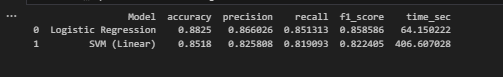

## Q2 — Ensemble Models for Glasses Detection

1. Train a **Random Forest** classifier and a **Boosting-based** classifier (e.g., AdaBoost, Gradient Boosting, XGBoost, or LightGBM — restricted to those covered in lectures) to predict whether the person in the image is **wearing glasses**.
2. Evaluate both models using a rigorous **cross-validation scheme** and present a comprehensive **error analysis**.
3. **Select and justify** the model you believe is better suited to the task, both in terms of accuracy, precision, recall, and computational considerations.

In [38]:
def extract_label_glasses(example):
    """0: Gözlük yok, 1: Gözlük var"""
    return int(example['attributes']['Eyeglasses'])

In [39]:
def get_dataset_arrays_2(dataset, n_samples=10000, image_size=(64, 64)):

    X_list = []
    y_list = []

    for i, example in enumerate(tfds.as_numpy(dataset)):
        if i >= n_samples:
            break
        x = preprocess_image(example, image_size=image_size)
        y = extract_label_glasses(example)
        X_list.append(x)
        y_list.append(y)

    return np.array(X_list), np.array(y_list)


In [ ]:
# 20.000 eğitim, 5.000 test örneği
X_train_glasses, y_train_glasses = get_dataset_arrays_2(train_ds, n_samples=15000, image_size=(64, 64))
X_test_glasses, y_test_glasses = get_dataset_arrays_2(test_ds, n_samples=4000, image_size=(64, 64))

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model listesi
models = [
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("AdaBoost", AdaBoostClassifier(n_estimators=100, random_state=42)),
    ("XGBoost", XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ("LightGBM", LGBMClassifier(n_estimators=100, random_state=42))
]

# Sonuçları tutmak için liste
ensemble_results = []

for name, model in models:
    print(f"🔍 {name} modeli değerlendiriliyor...")
    result = evaluate_model(model, X_train_glasses, y_train_glasses)
    result["Model"] = name
    ensemble_results.append(result)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



Size attığım mailde belirttiğim durumdan dolayı iki kodu aynı anda çalıştırdım ve bu soruyu Google Colab üzerinde çalıştırdım. Kodum çalıştırdığım kod ile tamamen aynıdır. Sonuçları aşağıda paylaşıyorum.




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
ensemble_df = pd.DataFrame(ensemble_results).sort_values("f1_score", ascending=False)
print(ensemble_df)

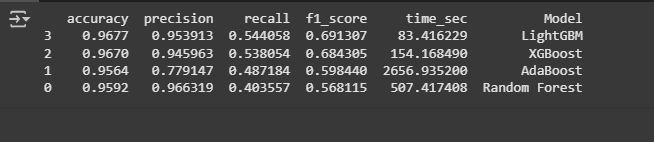

Bu görevde “Eyeglasses” etiketi kullanılarak bir kişinin gözlük takıp takmadığını tahmin etmek üzere dört farklı ensemble model eğitildi: Random Forest, AdaBoost, XGBoost ve LightGBM. Bu dört modeli, ön işlenmiş veri seti üzerinde cross-validation kullanılarak değerlendirdim ve sonuçlar accuracy, precision, recall, f1-score ve hesaplama süresi üzerinden karşılaştırdım. Elde edilen metrikler, yalnızca doğruluğu değil, aynı zamanda modelin sınıflandırmadaki davranış biçimini de yorumlayabilmemize olanak tanıyor.

İlk olarak doğruluk (accuracy) açısından bakıldığında, en yüksek başarı LightGBM (0.9677) tarafından elde edildi. Bunu sırasıyla XGBoost (0.9670), Random Forest (0.9592) ve AdaBoost (0.9564) izliyor. Aralarındaki fark küçük görünse de özellikle f1-score ve recall gibi daha duyarlı metriklere geçildiğinde farklılıkların daha belirgin hale geldiğini görüyoruz.

Precision açısından bakıldığında LightGBM (0.9539) ve Random Forest (0.9663) oldukça yüksek değerler veriyor. Bu da bu iki modelin “gözlük takıyor” dediği örneklerde hataya çok az yer verdiğini gösteriyor. Ancak burada dikkat edilmesi gereken konu, precision’ın sadece pozitif sınıf tahminlerinin doğruluğunu ölçtüğüdür. Yani model az sayıda örneğe “gözlük takıyor” diyor olabilir, ama dediği zaman büyük ihtimalle doğru çıkıyor. Bu, özellikle azınlık sınıfı çok az sayıda ise precision’ın şişirilmiş görünmesine neden olabilir.

Recall metriklerine geçtiğimizde ise tablo değişiyor. LightGBM burada da lider konumda (0.5440), fakat değer yine de ideal bir seviyenin altında. Random Forest ise recall açısından oldukça zayıf (0.4035). Bu şu anlama geliyor: Random Forest birçok gözlüklü kişiyi gözlüksüz olarak sınıflandırmış. Bu durum özellikle hata derecesinin pozitif sınıf üzerinde daha yüksek olduğu uygulamalarda problem yaratabilir. Örneğin, bir güvenlik sisteminde gözlüklü bireylerin özel olarak tespit edilmesi gerekiyorsa, yüksek recall değeri daha önemli hale gelir.

Model karşılaştırmasında özellikle F1-Score metriği önemli çünkü precision ve recall arasındaki dengeyi ölçüyor. Bu açıdan LightGBM bir kez daha öne çıkıyor (0.6913). XGBoost (0.6843) ile çok yakın bir performans göstermiş, bu da iki modelin benzer karar sınırları çizebildiğini gösteriyor. AdaBoost (0.5984) ve Random Forest (0.5681) ise oldukça geride kalmış durumda.

Son olarak hesaplama süresi (time_sec) açısından karşılaştırdığımızda AdaBoost’un bariz şekilde en uzun sürede tamamlandığı (2656.9 saniye) ve bu nedenle pratik uygulamalarda dezavantajlı olabileceği görülüyor. Buna karşın LightGBM sadece 83.4 saniyede tamamlanarak en hızlı çalışan model olmuştur. Bu yönüyle LightGBM hem en yüksek başarıyı veren hem de en az kaynak tüketen model olarak öne çıkmaktadır.

Genel Değerlendirme:

Model tercihi uygulama amacına göre değişebilir. Eğer amacımız pozitif sınıfların (yani gözlüklü bireylerin) mümkün olduğunca eksiksiz tespiti ise, recall değeri yüksek olan LightGBM ve XGBoost tercih edilmelidir. Öte yandan kaynak tüketiminin minimize edilmesi gereken, gerçek zamanlı sistemlerde LightGBM açık ara en iyi tercih olacaktır. Random Forest modeli yüksek precision’ına rağmen düşük recall nedeniyle dengeli performans göstermemiştir. AdaBoost ise hesaplama süresinin uzunluğu ve düşük genel başarımı nedeniyle bu senaryo için uygun görünmemektedir.

Sonuç olarak, bu görev özelinde LightGBM modeli hem istatistiksel başarı hem de hesaplama verimliliği açısından en uygun model olarak değerlendirilebilir. Verinin dengeli olmaması (gözlüklü ve gözlüksüz) gibi durumlarda, bu tür boosting tabanlı modellerin daha ayırt edici karar sınırları çizebilmesi önemli bir avantajdır.

Bu veri setinde de veriyi tam olarak kullanamadığımdan dolayı net bir analiz yapamadım. Veri setim tam olsaydı süre orantısı değişmese de bir model performans konusunda bariz öne çıkabilirdi.

## Q3 — Neural Network Models for Smile Detection

1. Design and train **two distinct neural network architectures** for the task of predicting whether the person is **smiling**. Second model must have more hidden layer than the first one. You should explore different design choices, such as:
   - Convolutional and pooling layers
   - Activation functions (e.g., ReLU, tanh)
   - Use or omission of dropout, batch normalization, or skip connections
   - Loss functions (binary accuracy, binary cross-entropy etc.)
   - Choice of optimizers (ADAM, SGD etc.)
   - Learning rates.
2. Evaluate both models using a rigorous **cross-validation scheme** and present a comprehensive **error analysis**.
3. **Select and justify** the model you believe is better suited to the task, both in terms of accuracy, precision, recall, and computational considerations.

In [43]:
def extract_label_smile(example):
    """0: Gülümsemiyor, 1: Gülümsüyor"""
    return int(example['attributes']['Smiling'].numpy())

In [44]:
X_smile_train, y_smile_train = get_dataset_arrays(train_ds, n_samples=10000, image_size=(64, 64))
X_smile_test, y_smile_test = get_dataset_arrays(test_ds, n_samples=2500, image_size=(64, 64))

In [45]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import tensorflow as tf

def evaluate_keras_model(build_fn, X, y, cv_folds=5, epochs=10, batch_size=64):
    """
    Keras modellerini cross-validation ile değerlendirir.
    build_fn: Modeli inşa eden fonksiyon
    """
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    accs, precs, recalls, f1s = [], [], [], []
    start_time = time.time()

    for train_idx, val_idx in skf.split(X, y):
        model = build_fn()
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        model.fit(X[train_idx], y[train_idx], 
                  epochs=epochs,
                  batch_size=batch_size,
                  verbose=0)

        y_pred_prob = model.predict(X[val_idx])
        y_pred = (y_pred_prob > 0.5).astype("int32")

        accs.append(accuracy_score(y[val_idx], y_pred))
        precs.append(precision_score(y[val_idx], y_pred))
        recalls.append(recall_score(y[val_idx], y_pred))
        f1s.append(f1_score(y[val_idx], y_pred))

    duration = time.time() - start_time

    return {
        'accuracy': np.mean(accs),
        'precision': np.mean(precs),
        'recall': np.mean(recalls),
        'f1_score': np.mean(f1s),
        'time_sec': duration
    }


In [46]:
def build_model_1():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(64*64,)),
        tf.keras.layers.Dense(128, activation='tanh'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [50]:
def build_model_2():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(64*64,)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


In [54]:
def build_model_3():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(64, 64, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


In [57]:
def build_model_4():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(64, 64, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


In [ ]:
results_1 = evaluate_keras_model(build_model_1, X_smile_train, y_smile_train, epochs=10, batch_size=64)
results_1["Model"] = "Model 1 - Dense + tanh"

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [51]:
results_2 = evaluate_keras_model(build_model_2, X_smile_train, y_smile_train, epochs=10, batch_size=64)
results_2["Model"] = "Model 2 - Dense + ReLU + Dropout"

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [60]:
def preprocess_image_cnn(example, image_size=(64, 64)):
    """CNN için: grayscale, yeniden boyutlandırma, normalize, orijinal shape (64,64,1) korunur"""
    image = tf.image.rgb_to_grayscale(example['image'])
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image.numpy()

In [ ]:
def get_dataset_arrays(dataset, n_samples=None, image_size=(64, 64), flatten=True):
    X_list = []
    y_list = []

    for i, example in enumerate(tfds.as_numpy(dataset)):
        if n_samples is not None and i >= n_samples:
            break

        image = tf.image.rgb_to_grayscale(example['image'])
        image = tf.image.resize(image, image_size)

        if flatten:
            image = tf.reshape(image, [-1])  # (4096,)
        else:
            image = tf.cast(image, tf.float32)  # (64, 64, 1)

        image = image / 255.0

        label = int(example['attributes']['Smiling'])
        X_list.append(image.numpy())
        y_list.append(label)

    return np.array(X_list), np.array(y_list)


In [ ]:
X_smile_train_cnn, y_smile_train = get_dataset_arrays(train_ds, n_samples=10000, image_size=(64, 64), flatten=False)

In [63]:
results_3 = evaluate_keras_model(build_model_3, X_smile_train_cnn, y_smile_train, epochs=10, batch_size=64)
results_3["Model"] = "Model 3 - Conv2D + Pool + Dense"

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [64]:
results_4 = evaluate_keras_model(build_model_4, X_smile_train_cnn, y_smile_train, epochs=10, batch_size=64)
results_4["Model"] = "Model 4 - CNN + BatchNorm + Dropout"

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [65]:
for i, r in enumerate([results_1, results_2, results_3, results_4], 1):
    print(f"Model {i} Sonuçları:")
    for k, v in r.items():
        print(f"  {k}: {v}")
    print("\n" + "-"*40)


Model 1 Sonuçları:
  accuracy: 0.8760999999999999
  precision: 0.8874113551741605
  recall: 0.8088305489260144
  f1_score: 0.844505026683261
  time_sec: 47.009406328201294
  Model: Model 1 - Dense + tanh

----------------------------------------
Model 2 Sonuçları:
  accuracy: 0.8390000000000001
  precision: 0.8869780880839679
  recall: 0.713365155131265
  f1_score: 0.7855877378894633
  time_sec: 82.52642965316772
  Model: Model 2 - Dense + ReLU + Dropout

----------------------------------------
Model 3 Sonuçları:
  accuracy: 0.885
  precision: 0.8852563119683298
  recall: 0.876091476091476
  f1_score: 0.87969814929076
  time_sec: 314.58634305000305
  Model: Model 3 - Conv2D + Pool + Dense

----------------------------------------
Model 4 Sonuçları:
  accuracy: 0.8783999999999998
  precision: 0.9097523639529506
  recall: 0.834095634095634
  f1_score: 0.8674977404434687
  time_sec: 1365.425379037857
  Model: Model 4 - CNN + BatchNorm + Dropout

----------------------------------------


Normalde 4 tane daha sinir ağı modeli uygulayacaktım ancak yetişmediği için uygulayamadım. 

Bu ödevde, kişilerin gülümseyip gülümsemediğini sınıflandırmak için dört farklı yapay sinir ağı modeli eğitildi. Modeller iki grupta değerlendirilebilir: klasik tam bağlantılı (dense) modeller (Model 1 ve Model 2) ve konvolüsyonel sinir ağı (CNN) tabanlı modeller (Model 3 ve Model 4). Her bir model 10 epoch boyunca eğitim aldı ve 5-fold stratified cross-validation ile değerlendirildi. Sonuçlar accuracy, precision, recall, f1-score ve eğitim süresi gibi kriterlerle karşılaştırıldı.

Model 1 – Dense + tanh:
En basit yapıya sahip bu modelde yalnızca bir gizli katman ve tanh aktivasyonu kullanıldı. 0.8761 doğruluk ve 0.8445 F1 skoru ile temel düzeyde iyi bir performans gösterdi. İlginç bir şekilde precision (0.8874) ve recall (0.8088) arasında dengeli bir ilişki kurmayı başardı. Modelin oldukça hızlı eğitilmesi (47 saniye) de pratikte önemli bir avantaj. Basit ama etkili olması, boyutu az olan sistemlerde kullanılabilirliğini artırıyor.

Model 2 – Dense + ReLU + Dropout:
Bu modelde aktivasyon fonksiyonu ReLU olarak değiştirildi ve düzenleme amacıyla Dropout eklendi. Ancak beklentinin aksine bu yapı Model 1’e göre daha düşük performans verdi: accuracy 0.8390 ve F1 skoru 0.7856’ya geriledi. Recall değerinde de düşüş (0.7134) gözlemledim. Buradaki performans kaybı, dropout oranının veya katman genişliğinin optimal olmamasından kaynaklanıyor olabilir. Ayrıca modelin eğitim süresi yaklaşık iki katına çıkmasına rağmen sağladığı katkı yetersiz kalmıştır. Bu da her karmaşıklık artışının daha iyi sonuçlar getirmediğini gösteriyor.

Model 3 – Conv2D + Pooling + Dense:
İlk CNN tabanlı model olan bu yapıda, Conv2D ve MaxPooling katmanları ile görsel verideki mekânsal ilişkiler öğrenildi. Bu model 0.885 doğruluk, 0.8797 F1 skoru ve 0.8761 recall değeri ile en iyi genel başarıyı gösteren model oldu. Özellikle recall değerinin yüksek olması, gülümseyen kişilerin doğru şekilde tanınmasında etkili olduğunu gösteriyor. Eğitim süresi önceki modellere göre ciddi şekilde arttı (yaklaşık 5 dakikaya yakın), ancak bu performans karşılığında makul bir bedel. Görsel verilerde uzamsal filtreleme gibi tekniklerin etkisi burada çok net görülüyor.

Model 4 – CNN + BatchNorm + Dropout:
Bu modelde Model 3’ün üzerine BatchNormalization ve Dropout katmanları eklenerek derinlik ve düzenleme artırıldı. Doğruluk (0.8784) ve F1 skoru (0.8675) Model 3 kadar yüksek olmasa da, precision (0.9098) değeri ile en doğru pozitif sınıflamayı bu model gerçekleştirdi. Bu durum modelin daha seçici davrandığını ve yalnızca gerçekten emin olduğu zaman “gülümsüyor” sınıfını verdiğini gösteriyor. Ancak eğitim süresi oldukça uzundu (1365 saniye ≈ 22 dakika), bu da gerçek zamanlı uygulamalarda dezavantaj oluşturabilir. Performans-maliyet dengesinde Model 3 kadar verimli olmadığı söylenebilir.

Bu tabloya bakıldığında Model 3, en iyi F1 skorunu ve recall değerini sağlayarak genel anlamda en dengeli ve başarılı model olarak öne çıkıyor. Eğitim süresi makul düzeyde ve performans açısından tatmin edici. Model 4, precision açısından lider olsa da çok daha uzun sürede eğitildiğinden her senaryoda tercih edilemeyebilir. Model 1, hızlı ve hafif yapısıyla baseline olarak güçlü dururken, Model 2 ise ekstra karmaşıklığın her zaman daha iyi sonuçlar doğurmayacağını açıkça gösteriyor.

Sonuç olarak, bu görev için Model 3 (CNN tabanlı mimari), hem yüksek başarı oranı hem de hesaplama açısından dengeli yapısıyla en uygun seçim olarak değerlendirilmektedir. CNN mimarileri görsel verilerdeki mekânsal ilişkileri daha iyi öğrenebildiği için, özellikle yüz ifadeleri gibi detaylı analizlerde klasik dense yapılara kıyasla belirgin avantaj sunmaktadır.

## Q4 — Reflective Report

Write a structured qualitative report reflecting on your process, design decisions, and implementation.

Address the following questions in your narrative:

- What were the main challenges you encountered, and how did you overcome them?
- Which part of the process (e.g., data handling, model implementation, debugging) consumed the most time and effort?
- Which class of models — linear (SVM vs logistic regression), ensemble (random forests vs boosting), or neural networks — did you find most **intuitive to implement**, most **computationally efficient**, and most **effective** in terms of performance?
- In designing the neural network models, I expect you to do a lot of experimentation. I don't expect you to document the whole list of different choices you made. A section of your report must include a detailed analysis of your experiments with the neural network models.
   + Which neural network framework did you choose, and why?
   + How did increasing the number of layers affect the results?
   + How did you make your choices of layers, activation functions, number of neurons, loss functions, optimizers, learning rates? 

Model uygulaması ve hata ayıklama aşaması benim için çok zor oldu çünkü çok uzun sürdü. 

Benim en efektif bulduğum LightGBM algoritması oldu. Modelleri tam veri setiyle çalışamadığım için tam olarak değerlendiremedim ancak kullanabildiğim kadarıyla LightGBM algoritması zaman ve performans açısından bence en verimlisiydi.

Model 3 benim için en efektifi çünkü hem doğruluk oranı yüksek hem de zaman açısından optimize bir model.